In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from SwarmPackagePy import pso  # Importando PSO
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score

train_dir = "..\isec-ic\\dataset\\train"
validation_dir = "..\isec-ic\\dataset\\valid"
test_dir = "..\isec-ic\\dataset\\test"

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))
train_dir = os.path.join(current_dir, train_dir)
validation_dir = os.path.join(current_dir, validation_dir)
test_dir = os.path.join(current_dir, test_dir)

#  "lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot"
categories = ["bacterialspot", "healthy" ]

def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder) 
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64)) 
                img = np.array(img) / 255.0 
                images.append(img)
                labels.append(categories.index(category))
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")
    return np.array(images), np.array(labels)

def create_cnn_model(num_neurons, learning_rate):
    input_shape = (64, 64, 3)
    num_classes = len(categories)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Aqui, o número de neurônios da única camada escondida é variável
    model.add(tf.keras.layers.Conv2D(num_neurons, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


def evaluate_model_PSO(solution):
    num_neurons, learning_rate = solution
    model = create_cnn_model(num_neurons, learning_rate)
    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)
    
    # Predições e cálculo do AUC
    y_pred = model.predict(x_validation)
    y_validation_categorical = to_categorical(y_validation, num_classes=len(categories))
    auc_score = roc_auc_score(y_validation_categorical, y_pred, multi_class='ovr')

    return 1 - auc_score  # Minimizar 1 - AUC


x_train, y_train = load_images_from_folder(train_dir)
x_validation, y_validation = load_images_from_folder(validation_dir)
x_test, y_test = load_images_from_folder(test_dir)

# Inicializar e executar PSO
print("Iniciando a otimização com PSO...")
num_agents = 2  # Número de agentes
max_iter = 3    # Número de iterações
dimension = 2    # Número de dimensões (neste caso, num_neurons e learning_rate)
lb = [10, 0.0001]   # Limites inferiores para num_neurons e learning_rate
ub = [100, 0.01]    # Limites superiores para num_neurons e learning_rate

# Criando a instância do PSO
pso_instance = pso(n=num_agents, function=evaluate_model_PSO, lb=lb, ub=ub, dimension=dimension, iteration=max_iter)
best_solution = pso_instance.get_Gbest()

best_num_neurons, best_learning_rate = best_solution
print(f"Melhores parâmetros encontrados: \nNúmero de Neurônios: {best_num_neurons}, Learning Rate: {best_learning_rate}")

Category: spidermite from subfolder Tomato__spidermite is not in the list of categories.
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categories.
Loading images from category: healthy and subfolder: Tomato___healthy
Category: lateblight from subfolder Tomato___Lateblight is not in the list of categories.
Category: leafmold from subfolder Tomato___Leafmold is not in the list of categories.
Category: septorialeafspot from subfolder Tomato___Septorialeafspot is not in the list of categories.
Category: targetspot from subfolder Tomato___Targetspot is not in the list of categories.
Category: mosaicvirus from subfolder Tomato___Tomato_mosaicvirus is not in the list of categories.
Category: yellowleafcurlvirus from subfolder Tomato___Tomato_yellowleafcurlvirus is not in the list of categories.
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Cat

Treinando o modelo com os melhores hiperparâmetros...
Epoch 1/10
94/94 [==============================] - 3s 25ms/step - loss: 0.3877 - accuracy: 0.8007 - val_loss: 0.1719 - val_accuracy: 0.9362
Epoch 2/10
94/94 [==============================] - 2s 24ms/step - loss: 0.1028 - accuracy: 0.9627 - val_loss: 0.1049 - val_accuracy: 0.9613
Epoch 3/10
94/94 [==============================] - 2s 24ms/step - loss: 0.0449 - accuracy: 0.9853 - val_loss: 0.0449 - val_accuracy: 0.9850
Epoch 4/10
94/94 [==============================] - 2s 24ms/step - loss: 0.0406 - accuracy: 0.9863 - val_loss: 0.1004 - val_accuracy: 0.9600
Epoch 5/10
94/94 [==============================] - 2s 24ms/step - loss: 0.0474 - accuracy: 0.9823 - val_loss: 0.0467 - val_accuracy: 0.9787
Epoch 6/10
94/94 [==============================] - 2s 24ms/step - loss: 0.0394 - accuracy: 0.9860 - val_loss: 0.0293 - val_accuracy: 0.9900
Epoch 7/10
94/94 [==============================] - 2s 24ms/step - loss: 0.0333 - accuracy: 0.9880 -

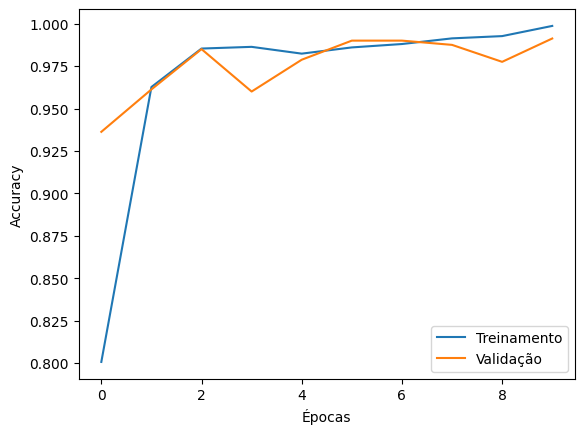

Avaliando o modelo no conjunto de teste...
Acurácia no Teste: 1.0, Loss: 0.0030732855666428804


In [4]:
import matplotlib.pyplot as plt

# Treinamento final e avaliação com os melhores hiperparâmetros
print("Treinando o modelo com os melhores hiperparâmetros...")
best_model = create_cnn_model(int(best_num_neurons), best_learning_rate)
best_model_history = best_model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(x_validation, y_validation))

best_pso_train_accuracy = best_model_history.history['accuracy'][-1]
best_pso_validation_accuracy = best_model_history.history['val_accuracy'][-1]

print("Melhor Accuracy de Treinamento (CNN PSO):", best_pso_train_accuracy)
print("Melhor Accuracy de Validação (CNN PSO):", best_pso_validation_accuracy)

# Plotar as curvas de treino e validação
plt.plot(best_model_history.history['accuracy'], label='Treinamento')
plt.plot(best_model_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Avaliando o modelo no conjunto de teste...")
loss, accuracy = best_model.evaluate(x_test, y_test, verbose=0)

print(f"Acurácia no Teste: {accuracy}, Loss: {loss}")
